In [36]:
%matplotlib inline
import copy, datetime, os, re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from scipy import stats
import data

In [37]:
results_path = 'results'

ids = ['{}_{}'.format(*p) for p in data.get_pairs()]

groups = [
    'df_cpu',
    'df_gpu',
    'ants'
]

structures = {}
structures['All'] = { 'name': 'All', 'brief': 'All' }

with open(os.path.join('structures.csv'), 'r') as f:
    l = f.readline() # Header
    for l in f:
        t = l.split(',')
        structures[t[0]] = { 'name': t[1], 'brief': t[2].strip() }

# Combine left and right
        
structures_combined = {}
for k, s in structures.items():
    brief = s['brief']
    name = s['name']
    if name[-1:] in ['L', 'R']:
        brief = brief[:-1]
        name = name[:-2]
    structures_combined[k] = { 'name': name, 'brief': brief }

In [38]:
# Load dice data

group_dice_data = []
for g in groups:
    pair_dice_data = []
    for p in ids:
        d = pandas.read_csv(os.path.join(results_path, g, '{}.csv'.format(p)))[['Label','Dice']]
        pair_dice_data.append(d)
    group_dice_data.append(pandas.concat(pair_dice_data, keys=ids, names=['pair']))
    
dice_data = pandas.concat(group_dice_data, keys=groups, names=['group'])
dice_data = dice_data.reset_index()
dice_data = dice_data.drop(columns='level_2')

dice_data['LabelName_All'] = dice_data['Label'].map(lambda x : structures[x]['brief'])
dice_data['LabelName'] = dice_data['Label'].map(lambda x : structures_combined[x]['brief'])

# Pretty group names
group_map = {
    'df_cpu': 'deform (CPU)',
    'df_gpu': 'deform (GPU)',
    'ants': 'ANTs'
}
dice_data['Method'] = dice_data['group'].map(lambda x : group_map[x])
dice_data = dice_data[dice_data.Label!='All'] # Drop All label, since we only care about individual labels
dice_data.groupby('Method').Dice.describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
ANTs,2375.0,0.700773,0.122498,0.091785,0.640520,0.718708,0.778938,0.943508
deform (CPU),2375.0,0.711792,0.123653,0.086734,0.656390,0.735000,0.789664,0.946410
deform (GPU),2375.0,0.711833,0.123498,0.086082,0.655233,0.735034,0.790001,0.947031


In [39]:
# Load run time

def to_datetime(s):
    return datetime.datetime.strptime(s, '%H:%M:%S.%f')

group_time_data = []
for g in groups:
    pair_time_data = []
    for p in ids:
        with open(os.path.join(results_path, g, '{}_log.txt'.format(p))) as f:
            lines = f.readlines()

        d = {}

        for i in range(0,5):
            d['level_{}'.format(i)] = None

        match = re.match('INF \d{2}-\d{2} (\d+:\d+:\d+.\d+) \|.*$', lines[0])
        if match:
            # deform
            start = to_datetime(match.group(1))
            match = re.match('INF \d{2}-\d{2} (\d+:\d+:\d+.\d+) \|.*$', lines[-4])
            stop = to_datetime(match.group(1))

            d['total'] = (stop - start).seconds

            current_level = None
            current_level_start = None

            for l in lines:
                m = re.match('INF \d{2}-\d{2} (\d+:\d+:\d+.\d+) \| Performing registration level (\d)+$', l)
                if m:
                    current_level_start = to_datetime(m.group(1))
                    current_level = m.group(2)
                m = re.match('INF \d{2}-\d{2} (\d+:\d+:\d+.\d+) \| Energy: \d+\.*\d*, Iterations: \d+$', l)
                if m:
                    stop = to_datetime(m.group(1))
                    d['level{}'.format(current_level)] = (stop - current_level_start).seconds
                    current_level = None
                    current_level_start = None
        else:
            # ANTs
            # Only time the SyN stage

            d['total'] = None
            for l in lines:
                m = re.match('\s*Elapsed time \(stage 2\): (\d+\.*\d*$)', l)
                if m:
                    d['total'] = float(m.group(1))
                    break
            
        
        df = pandas.DataFrame([d], columns=['total'] + ['level{}'.format(l) for l in range(0,5)])
        pair_time_data.append(df)
    group_time_data.append(pandas.concat(pair_time_data, keys=ids, names=['pair']))
time_data = pandas.concat(group_time_data, keys=groups, names=['group'])
time_data = time_data.reset_index()
time_data = time_data.drop(columns='level_2')
time_data['Method'] = time_data['group'].map(lambda x : group_map[x])
time_data.groupby('Method').total.describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
ANTs,25.0,826.136,47.623785,759.8,774.1,827.6,865.6,903.7
deform (CPU),25.0,419.040,33.593749,367.0,395.0,409.0,437.0,485.0
deform (GPU),25.0,109.680,11.473593,90.0,99.0,113.0,117.0,125.0


In [61]:
print(dice_data[(dice_data.group=='df_gpu')].describe())
print(dice_data[(dice_data.group=='ants')].describe())
t, p = stats.ttest_rel(list(dice_data[(dice_data.group=='df_gpu')].Dice), list(dice_data[(dice_data.group=='ants')].Dice))
print('t-test: p={}'.format(p))

              Dice
count  2375.000000
mean      0.711833
std       0.123498
min       0.086082
25%       0.655233
50%       0.735034
75%       0.790001
max       0.947031
              Dice
count  2375.000000
mean      0.700773
std       0.122498
min       0.091785
25%       0.640520
50%       0.718708
75%       0.778938
max       0.943508
t-test: p=2.7466993922068387e-53


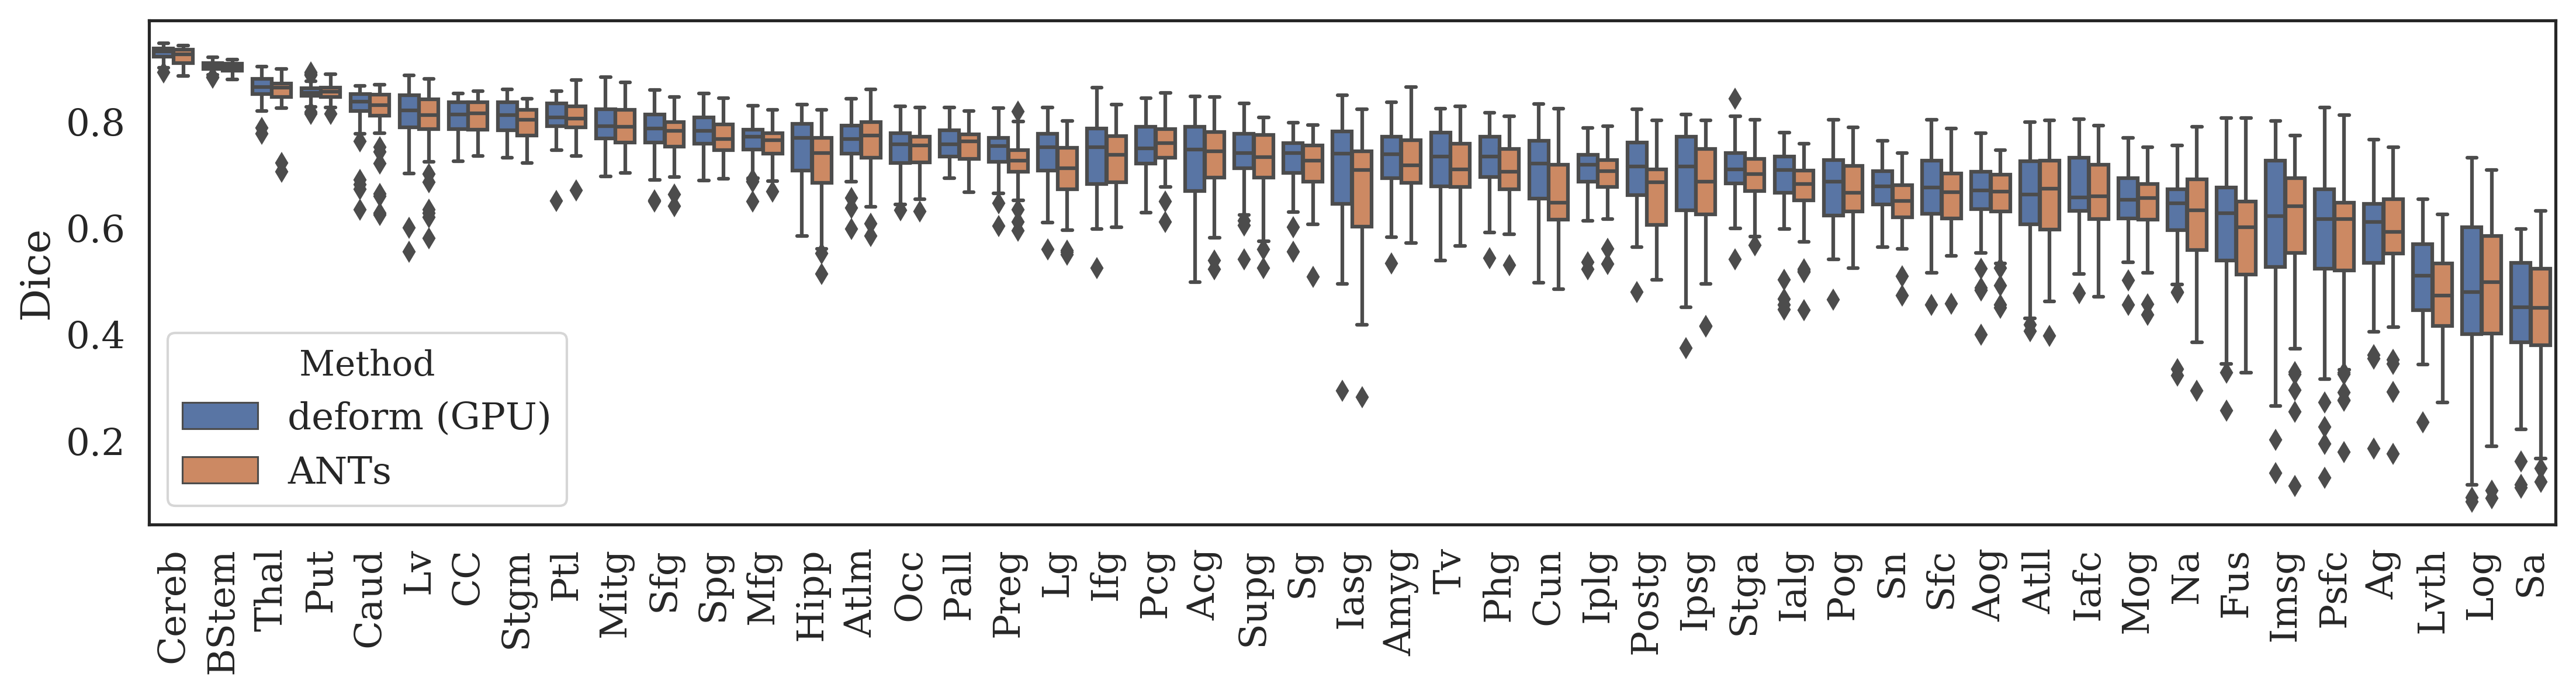

In [41]:
# Sort region dice in boxplot by median

medians = dice_data[dice_data.group=='df_gpu'].groupby('LabelName').median()
medians = medians.sort_values('Dice', ascending=False)

dice_data_median = dice_data.copy()
dice_data_median.LabelName = dice_data_median.LabelName.astype('category')
dice_data_median.LabelName.cat.set_categories(list(medians.index), inplace=True)
dice_data_median = dice_data_median.sort_values(['LabelName', 'Method'], ascending=[True, False])
dice_data_median = dice_data_median.reset_index()

sns.set(font_scale=1.4)
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

fig=plt.figure(figsize=(15, 4.25), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_axes()

ax = sns.boxplot(data=dice_data_median[dice_data_median.group.isin(['df_gpu','ants'])], y='Dice', x='LabelName', hue='Method', ax=ax)
ax.set(xlabel='')
_ = plt.xticks(rotation=90)
fig.tight_layout()
fig.savefig('figures/results_dice_box.pdf', pad_inches=0, bbox_inches='tight')

In [42]:
# Load jacobian determinant data

group_njac_data = []
for g in groups:
    d = pandas.read_csv(os.path.join(results_path, g, 'njac.csv'))[['fixed', 'moving', 'njac']]
    group_njac_data.append(d)

njac_data = pandas.concat(group_njac_data, keys=groups, names=['group'])
njac_data = njac_data.reset_index()

# Pretty group names

njac_data['Method'] = njac_data['group'].map(lambda x : group_map[x])
njac_data.groupby('Method').njac.describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
ANTs,25.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
deform (CPU),25.0,34.6,82.192356,0.0,0.0,0.0,4.0,280.0
deform (GPU),25.0,36.2,88.595523,0.0,0.0,0.0,5.0,316.0


In [43]:
# Profiling

prof_cpu = pandas.read_csv('results/prof_cpu.csv')
prof_gpu = pandas.read_csv('results/prof_gpu.csv')

In [44]:
prof_cpu

,name,total,calls,avg,min,max
0,block,221934.591019,7800.0,28.453153,0.000332,129.968638
1,shift,18538.421351,2.0,9269.210675,9223.210733,9315.210618
2,minimize,24121.523859,23400.0,1.030834,0.008148,23.072840
3,red_black,18538.413770,4.0,4634.603442,4603.039156,4662.202399
4,build,197499.164807,23400.0,8.440135,0.024363,31.852719
5,apply,157.559116,7850.0,0.020071,0.005835,0.125255


In [45]:
# Download phi is calculated as:
# Total device to host (DtoH) / (num blocks*num iterations) (22466)

download_phi = float(prof_gpu[prof_gpu.name=='[CUDA memcpy DtoH]'].total) / 22466

# Upload L is calculated as:
# (Total device to host (HtoD) - time to upload image pairs) / (num blocks*num iterations)

upload_L = (float(prof_gpu[prof_gpu.name=='[CUDA memcpy HtoD]'].total)-float(prof_gpu[prof_gpu.name=='upload_image_pair'].total)) / 22466

print('download_phi: {}'.format(download_phi)) 
print('upload_L: {}'.format(upload_L)) 

prof_gpu

download_phi: 0.025237291907771745
upload_L: 0.003631026618000534


,name,total,calls,avg,min,max
0,step,3948.595748,24.0,164.524823,144.075883,207.350250
1,iteration,3948.625020,2.0,1974.312510,0.000542,3948.624478
2,apply_displacement,14.159000,24.0,0.589958,0.586588,0.592413
3,shift,3948.621141,2.0,1974.310570,1826.572546,2122.048595
4,red_black,3948.616652,4.0,987.154163,904.331516,1137.186111
5,binary_function,292.417000,22466.0,0.013016,0.006177,2.584924
6,[CUDA memset],0.019000,26.0,0.000731,0.000608,0.001024
7,block_cost,9696.477541,22464.0,0.431645,0.042006,42.845132
8,minimize_block,34021.920053,22464.0,1.514509,0.017984,42.149878
9,upload_image_pair,6.260356,1.0,6.260356,6.260356,6.260356
